In [8]:
from __future__ import division
from __future__ import print_function
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import GPy
from scipy.stats import norm
from GPz.util import GpyParameterSearch
from sklearn.metrics import r2_score
from pandas import Series, DataFrame
from sklearn import cross_validation
from IPython.core.pylabtools import figsize

SAVE_FIG = True

if SAVE_FIG:
    from matplotlib import rcParams  
    rcParams['axes.labelsize'] = 9  
    rcParams['xtick.labelsize'] = 9  
    rcParams['ytick.labelsize'] = 9  
    rcParams['legend.fontsize'] = 9 
    default_fig_w = 8
    default_fig_h = 5
else:
    default_fig_w = 16
    default_fig_h = 10

%matplotlib inline
figsize(default_fig_w, default_fig_h)

In [2]:
df_std1 = pd.read_csv('../data/std1_mh_11_pubchem_hmdb.csv', keep_default_na=False)
df_std2 = pd.read_csv('../data/std2_mh_11_pubchem_hmdb.csv', keep_default_na=False)

# Removed heavy molecules
df_std1 = df_std1[df_std1['EXACT_MASS'] <= 280]
df_std2 = df_std2[df_std2['EXACT_MASS'] <= 280]

df_std1.drop(0, axis=0, inplace=True)
df_std1['JCHEM_ACIDIC_PKA'] = df_std1['JCHEM_ACIDIC_PKA'].astype(float)

df_merged = pd.concat([df_std1, df_std2])
df_merged.reset_index(inplace=True, drop=True)

df_merged['Dil_M'] = df_merged['Dil_1_1']

max_intensity = df_merged['Dil_1_1'].max()
df_merged['Dil_1_1'] = df_merged['Dil_1_1'] / max_intensity
df_merged['RRF'] = df_merged['Dil_1_1']
df_merged['Dil_1_1'] = np.log(df_merged['Dil_1_1'])

EXT_X_train, EXT_X_test, EXT_y_train, EXT_y_test = cross_validation.train_test_split(
    df_merged, df_merged[['Dil_1_1']], test_size=0.25, random_state=3)

In [3]:
N_FOLDS = 5

features = [
    u'JCHEM_ACIDIC_PKA',
    u'JCHEM_LOGP',
    u'JCHEM_POLARIZABILITY',
    u'JCHEM_POLAR_SURFACE_AREA',
]

cv_helper = GpyParameterSearch(features=features, n_folds=N_FOLDS)

# Cross Validation

In [4]:
arr_lengthscale = np.linspace(100, 200, num=50)
arr_variance = np.linspace(40e6, 50e6, num=50)
arr_noise_variance = [4.333] #np.linspace(3, 7, num=10)

df_results = cv_helper.cross_validation_scoring(
    EXT_X_train[cv_helper.features],
    EXT_y_train, 
    arr_lengthscale,
    arr_variance,
    arr_noise_variance)
df_grid_scores = cv_helper.calculate_scores(df_results)

Training on Fold 1/5
Training on Fold 1/5 Completed - 0:00:24.857339
Training on Fold 2/5
Training on Fold 2/5 Completed - 0:00:23.610581
Training on Fold 3/5
Training on Fold 3/5 Completed - 0:00:24.617391
Training on Fold 4/5
Training on Fold 4/5 Completed - 0:00:23.994020
Training on Fold 5/5
Training on Fold 5/5 Completed - 0:00:21.553212


# Best parameters based on predictive likelihood

In [5]:
p_mll = df_grid_scores[df_grid_scores['avg_mll'] == df_grid_scores['avg_mll'].max()]
p_mll

,ls,var,nvar,avg_r2,avg_mse,avg_mll
1981,179.591837,46326530.612245,4.333,-0.691227,12.365756,-29.983085


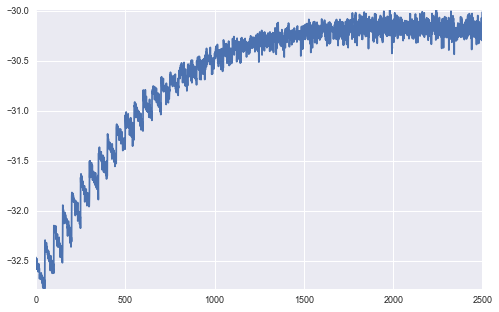

In [6]:
plt.plot(df_grid_scores.index, df_grid_scores['avg_mll'])
plt.ylim([max(-100, df_grid_scores['avg_mll'].min()), df_grid_scores['avg_mll'].max()])
plt.show()

# Validation Plot & Training Plot

Validating on holdout data

Test Log-likelihood -52.9601460664


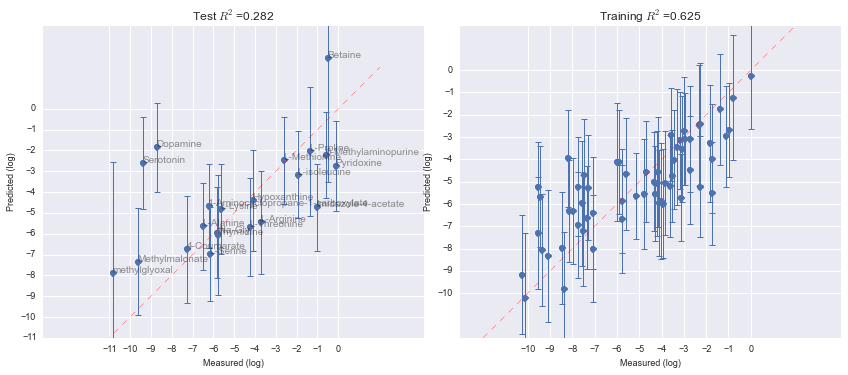

In [9]:
ls = p_mll['ls']
var = p_mll['var']
noise_var = p_mll['nvar']

figsize(1.45 * default_fig_w, default_fig_h)

plt.subplot(1, 2, 1)
mu_, s_ = cv_helper.predict(EXT_X_train[cv_helper.features], EXT_y_train, EXT_X_test[cv_helper.features], ls, var, noise_var)
r2 = r2_score(EXT_y_test['Dil_1_1'], mu_)
cv_helper.plot_results(EXT_y_test['Dil_1_1'], mu_, s_, title='Test $R^2$={:.3f}'.format(r2), labels=EXT_X_test['Name'])

likelihood = np.sum([norm.logpdf(t[0], loc=t[1], scale=t[2]) for t in zip(EXT_y_test['Dil_1_1'], mu_, s_)])
print('Test Log-likelihood', likelihood)

plt.subplot(1, 2, 2)
mu_train, s_train = cv_helper.predict(EXT_X_train[cv_helper.features], EXT_y_train, EXT_X_train[cv_helper.features], ls, var, noise_var)
r2 = r2_score(EXT_y_train['Dil_1_1'], mu_train)
cv_helper.plot_results(EXT_y_train['Dil_1_1'], mu_train, s_train, title='Training $R^2$={:.3f}'.format(r2))

plt.tight_layout(pad=0.1)

if SAVE_FIG:
    plt.savefig('../figures/hmdb_gu_gp_regression.pdf')

plt.show()

# Detailed Validation Plot

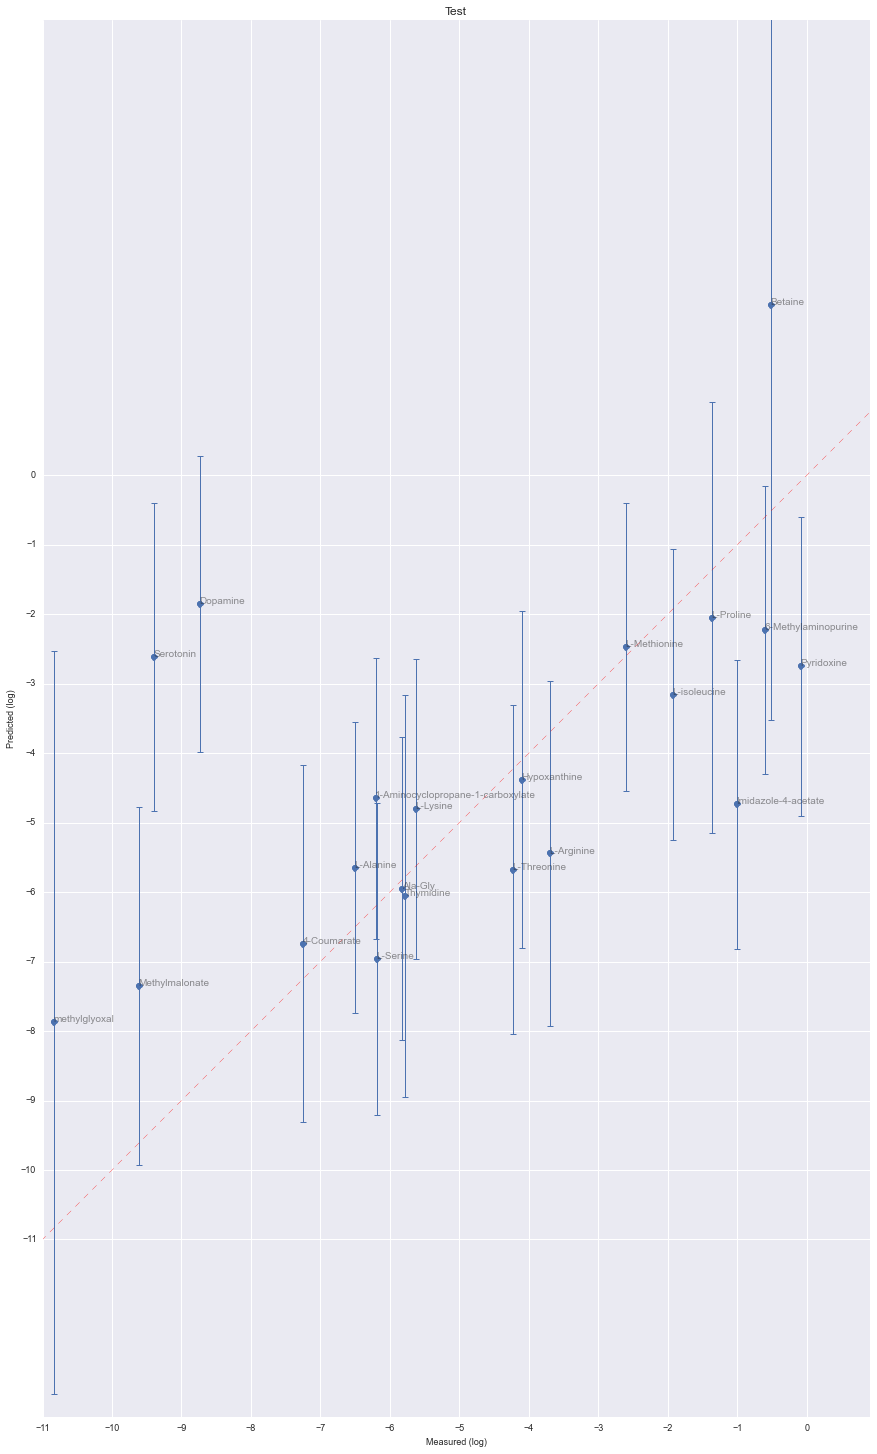

In [10]:
plt.figure(figsize=(12, 20))
mu_, s_ = cv_helper.predict(EXT_X_train[cv_helper.features], EXT_y_train, EXT_X_test[cv_helper.features], ls, var, noise_var)
cv_helper.plot_results(EXT_y_test['Dil_1_1'], mu_, s_, title='Test', labels=EXT_X_test['Name'])
plt.tight_layout(pad=0.1)
plt.show()

# Draw samples

In [11]:
NUM_SAMPLES = 1000

def draw_adjusted_samples(row):
    """
    Draw sample from the predicted distribution
    and adjust it by substracting the true value
    """
    return list(np.exp(np.random.normal(row['mu'], row['scale'], NUM_SAMPLES)))

df_results = DataFrame(
    {
        'Name': EXT_X_test['Name'],
        'mu': mu_.ravel(),
        'scale': s_.ravel(), 
        'logDil': EXT_y_test['Dil_1_1']
    },
    columns=['Name', 'logDil', 'mu', 'scale'])
df_results['samples'] = df_results.apply(draw_adjusted_samples, axis=1)

df_results.head(10)

,Name,logDil,mu,scale,samples
12,L-Proline,-1.359919,-2.047126,3.095635,"[0.000401206480244, 0.249403628642, 0.15207582..."
17,L-Threonine,-4.224677,-5.674515,2.372790,"[0.0027841629961, 0.00708927095435, 0.05809067..."
6,L-Methionine,-2.596133,-2.474054,2.076804,"[0.0362422659779, 0.0542385974003, 0.420186618..."
36,Thymidine,-5.778691,-6.057437,2.891380,"[0.000272423779382, 0.00395893888424, 0.002101..."
32,L-Arginine,-3.692706,-5.443636,2.479560,"[0.0765255418775, 0.00566805037895, 0.00079302..."
68,Ala-Gly,-5.824964,-5.948071,2.181957,"[0.0107477082312, 0.00102290965074, 0.03091282..."
74,Dopamine,-8.729106,-1.850941,2.131776,"[0.542571569726, 0.257042034744, 0.02458047695..."
9,Imidazole-4-acetate,-1.002133,-4.736343,2.084921,"[0.124814797311, 0.000627938176971, 0.00277660..."
8,Pyridoxine,-0.087757,-2.749999,2.149670,"[0.00576917339133, 0.147909999014, 0.866803001..."
47,Hypoxanthine,-4.094681,-4.380653,2.426398,"[0.00173486881497, 0.00124750255956, 0.0015839..."


In [12]:
df_bc = pd.concat([df_merged.ix[df_results.index][['Name', 'Dil_M', 'RRF']], df_results['samples']], axis=1)
df_bc['Corrected'] = df_bc.apply(lambda x: list(x['RRF'] / np.array(x['samples'])), axis=1)
df_bc['Corrected_Median'] = df_bc['Corrected'].apply(lambda c: np.median(c))
df_bc.head(3)
df_bc[['Name', 'Corrected_Median']].to_csv('../data/hmdb_gu_correction.csv', index=False)

In [13]:
df_bc['Corrected_diff'] = df_bc['Corrected_Median'].apply(lambda x: np.abs(np.log10(x)))
df_bc['Measured_diff'] = df_bc['RRF'].apply(lambda x: np.abs(np.log10(x)))
df_bc['IsItBetter'] = df_bc.apply(lambda x: x['Corrected_diff'] < x['Measured_diff'], axis=1)

In [14]:
print('True', len(df_bc[df_bc['IsItBetter'] == True]))
print('False', len(df_bc[df_bc['IsItBetter'] == False]))

True 17
False 4


In [15]:
is_better = df_bc['IsItBetter'].reset_index(drop=True)

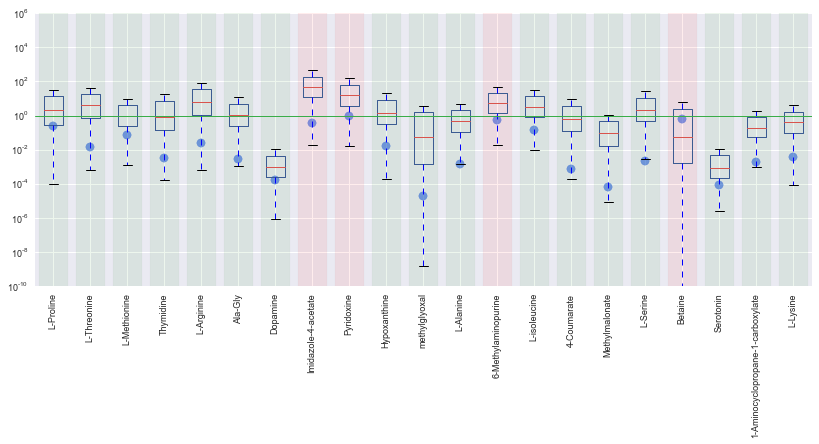

In [16]:
figsize(1.4 * default_fig_w, 1.2 * default_fig_h)
plt.figure()
plt.scatter(np.arange(1, len(df_bc['RRF']) + 1), df_bc['RRF'], color=sns.xkcd_rgb["blue"], marker='o', s=70, alpha=0.5)

boxprops = dict(linestyle='-', linewidth=1, color=sns.xkcd_rgb["denim blue"])

medianprops = dict(linestyle='-', linewidth=1, color=sns.xkcd_rgb["pale red"])

meanlineprops = dict(linestyle='-', linewidth=1, color=sns.xkcd_rgb["denim blue"])

whiskerprops = dict(linestyle='--', linewidth=1)

capprops = dict(linestyle='-', linewidth=1)

plt.boxplot(list(df_bc['Corrected']), labels=df_bc['Name'].values, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
plt.yscale('log')

plt.bar(is_better[is_better == True].index + 1, [1e16] * len(is_better[is_better == True]), color='green', alpha=0.07, align='center')
plt.bar(is_better[is_better == False].index + 1, [1e16] * len(is_better[is_better == False]), color='red', alpha=0.07, align='center')

plt.axhline(1, color=sns.xkcd_rgb["medium green"], linewidth=1)
plt.xticks(rotation=90)
plt.grid(True)
plt.ylim([1e-10, 1e6])

plt.tight_layout(pad=0.1)

if SAVE_FIG:
    plt.savefig('../figures/hmdb_gu_correction.pdf')

plt.show()